<a href="https://colab.research.google.com/github/Arnoldzyf/Apziva-Projects/blob/main/2_Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

# Check the Data

## Load the Data

In [3]:
path = "/content/drive/MyDrive/Apziva/Project 2 - Term Deposit Marketing/Resources/term-deposit-marketing-2020.csv"
data_df = pd.read_csv(f"{path}")
data_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


**Attributes:**

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output** (desired target):

- y - has the client subscribed to a term deposit? (binary)


## Statistics

### Label Distribution

In [4]:
print(data_df["y"].value_counts(normalize=False, dropna=False))
print()
print(data_df["y"].value_counts(normalize=True, dropna=False))

no     37104
yes     2896
Name: y, dtype: int64

no     0.9276
yes    0.0724
Name: y, dtype: float64


- Data is extremely unbalanced
  - ?? Upsampling



### Data Type and Missing Values

In [5]:
## Data Type and Missing Values
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


- No obvious missing values
- ?? May need to handle "unknown" values
  - Keep it as "unknown" and treat it as a categor, or
  - Convert them back to NaN, or
  - Imputation
    - M1: use the most frequent / mean / median to replace it directly
    - M2: build a small predictor, use other features to predict it

### Numeric Features

In [6]:
data_df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


- Need some rescaling

### Categorical Features

In [7]:
data_df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,y
count,40000,40000,40000,40000,40000,40000,40000,40000,40000
unique,12,3,4,2,2,2,3,11,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,no
freq,9383,24386,20993,39191,24031,33070,24914,13532,37104


In [8]:
def print_column_value_counts(df, columns, normalize=True, dropna=False):
  for col in columns:
    print(f"------- {col}: --------")
    print(f"-- #unique: {df[col].nunique()}")
    print(df[col].value_counts(normalize=normalize, dropna=dropna))
    print()

print_column_value_counts(df = data_df, \
                          columns = list(data_df.select_dtypes(include='object').columns), \
                          normalize=False, dropna=False)

------- job: --------
-- #unique: 12
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

------- marital: --------
-- #unique: 3
married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

------- education: --------
-- #unique: 4
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

------- default: --------
-- #unique: 2
no     39191
yes      809
Name: default, dtype: int64

------- housing: --------
-- #unique: 2
yes    24031
no     15969
Name: housing, dtype: int64

------- loan: --------
-- #unique: 2
no     33070
yes     6930
Name: loan, dtype: int64

------- contact: --------
-- #unique: 3
cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int6

* Features that contains "unknown" are: `job, education, contact`.

# Split Data

In [9]:
train, test = train_test_split(data_df, test_size=0.2, random_state=42)
# train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Training set has {len(train)} samples")
# print(f"Validation set has {len(val)} samples")
print(f"Test set has {len(test)} samples")

Training set has 32000 samples
Test set has 8000 samples


# Data Pre-processing

Should calculate and implement on `train`, and then apply to `test` without seeing the test set.

## Help Functions

In [38]:
def count_and_average_of_label_by_feature_via_bins(df, feature, label, \
                                                   bins=100, colors=['b','r']):
  """
  put feature values in bins
  count feature occurrences and corresponding average label value in a bin
  """
  ## Plotting
  fig, ax1 = plt.subplots()

  ## Compute average of label value for each bin of feature value
  bin_sum_y, bin_edges, _ =  plt.hist(df[feature], bins=bins, weights=df[label], alpha=0)
  bin_count, _, _ = plt.hist(df[feature], bins=bins)

  bin_means = bin_sum_y / bin_count  # Compute the average for each bin

  ## Histogram of the feature column
  ax1.hist(df[feature], bins=bins, alpha=0.7, color=colors[0], label=f'Frequency of {feature}')  ## ?? color will be disabled if this hist is written after the above two hist
  ax1.set_xlabel(f'Values of {feature}')
  ax1.set_ylabel('Frequency', color=colors[0])
  ax1.tick_params('y', colors=colors[0])

  ## Plotting average of label value corresponding to each bin of the feature
  ax2 = ax1.twinx()
  ax2.plot((bin_edges[:-1] + bin_edges[1:]) / 2, bin_means, color=colors[1], label=f'Average of {label}')
  ax2.set_ylabel(f'Average of {label}', color=colors[1])
  ax2.tick_params('y', colors=colors[1])

  ## Show legend
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  plt.title(f'Histogram and Average of {label} vs bins of {feature}')
  plt.show()


def count_and_average_of_label_by_feature(df, feature, label, \
                                          show_plot=True, use_frequency=True, \
                                          colors=['tab:blue', 'tab:red'], marker='.'):
  """
  For each value of feature, count its occurrences and corresponding average label value
  ---
  input: df: datframe, feature: string, label: string
  """
  # Group by 'feature' and calculate count and mean of 'label'
  grouped = train.groupby(feature)[label].agg(['count', 'mean'])

  # Reset index to make 'label' a column again
  grouped.reset_index(inplace=True)

  # frequncy
  grouped['frequency'] = grouped['count'] / len(df)

  if show_plot:
    # Plot
    fig, ax1 = plt.subplots()

    # Create bar chart for count of occurrences of 'age'
    occur="count"
    if use_frequency:
      occur="frequency"
    color = colors[0]
    ax1.set_xlabel(feature)
    ax1.set_ylabel(occur, color=color)
    ax1.bar(grouped[feature], grouped[occur], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for the line plot
    ax2 = ax1.twinx()
    color = colors[1]
    ax2.set_ylabel(f'Average {label}', color=color)
    ax2.plot(grouped[feature], grouped['mean'], color=color, marker=marker)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and show plot
    plt.title(f'Count and Average of {label} by {feature}')
    plt.show()

  return grouped

## Label 'y'

### Convert Label to Numerics

Otherwise there'll be errors when using xbg.DMatrix.

In [11]:
# Define mapping dictionary
mapping = {'yes': 1, 'no': 0}

# Use map function to apply the mapping on the training set
train['y_numeric'] = train['y'].map(mapping)


## Apply the same on the test set
test['y_numeric'] = test['y'].map(mapping)

## F - 'age'

### Plot - Count and Average of y by Age

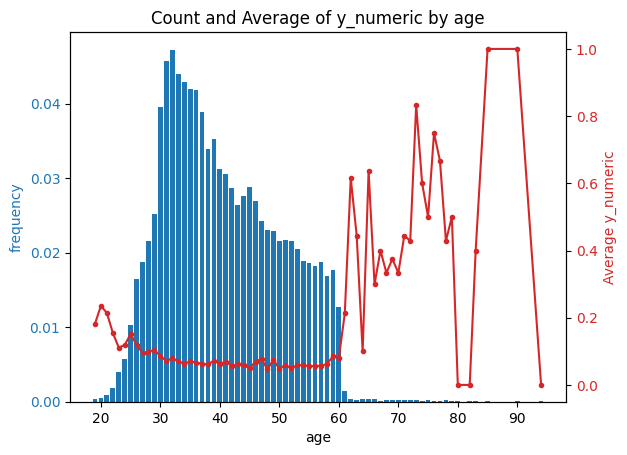

,age,count,mean,frequency
0,19,11,0.181818,0.000344
1,20,17,0.235294,0.000531
2,21,28,0.214286,0.000875
3,22,58,0.155172,0.001813
4,23,126,0.111111,0.003938
...,...,...,...,...
62,82,3,0.000000,0.000094
63,83,5,0.400000,0.000156
64,85,2,1.000000,0.000063
65,90,1,1.000000,0.000031


In [12]:
count_and_average_of_label_by_feature(train, 'age', 'y_numeric')

? Put Age into bins

## F - 'balance'

### Check Frequency

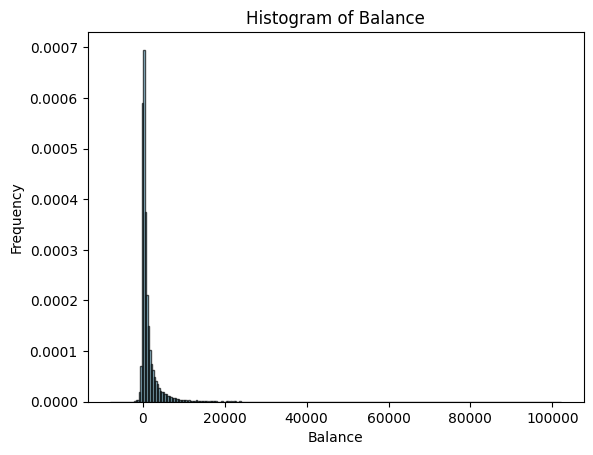

In [67]:
plt.hist(train['balance'], bins=300, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Balance')
plt.show()

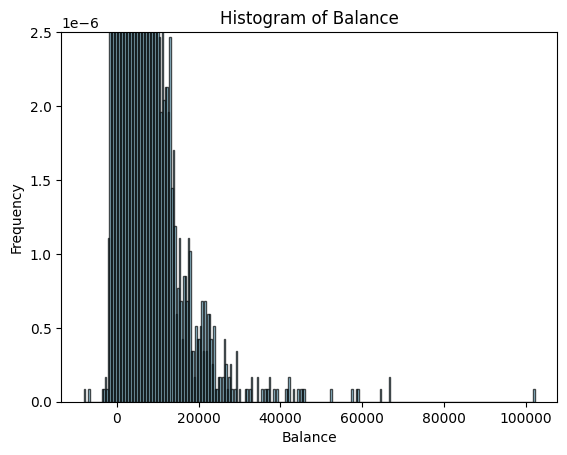

In [13]:
plt.hist(train['balance'], bins=300, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Balance')

plt.ylim(0,0.0000025)
plt.show()

### M1: Min-Max Normalization

In [16]:
""" On the training set"""
data = train['balance']

## Trimming to exlude outliers,  trim_percent=0.5%
trim_percent = 0.5
lower_bound = np.percentile(data, trim_percent)
upper_bound = np.percentile(data, 100 - trim_percent)

data = np.clip(data, lower_bound, upper_bound)  ## outliers will be converted to edges

## min-max normalization, to range[0, 1]
min_range, max_range = 0, 100
normalized_data = (data - lower_bound) / (upper_bound - lower_bound) * (max_range - min_range) + min_range

train['balance_minmax'] = normalized_data

"""On the test set"""
## use the same bound and range as training data
data = test['balance']
data = np.clip(data, lower_bound, upper_bound)
normalized_data = (data - lower_bound) / (upper_bound - lower_bound) * (max_range - min_range) + min_range

test['balance_minmax'] = normalized_data

**Check frequency**

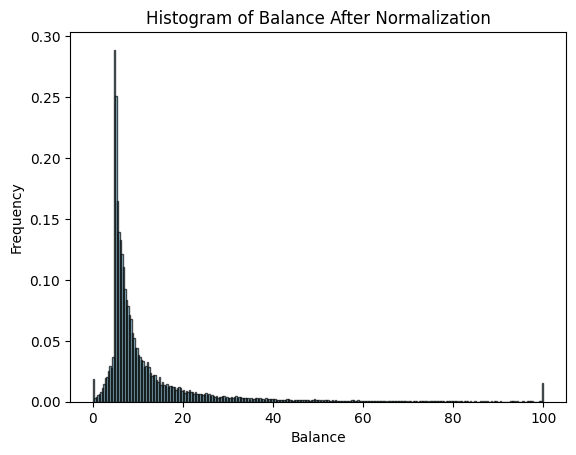

In [28]:
"""Check frequency on traing set after normalization"""
plt.hist(train['balance_minmax'], bins=300, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Balance After Normalization')
# plt.ylim(0,0.0000025)
plt.show()

**Plot - Count and average of y by balance**

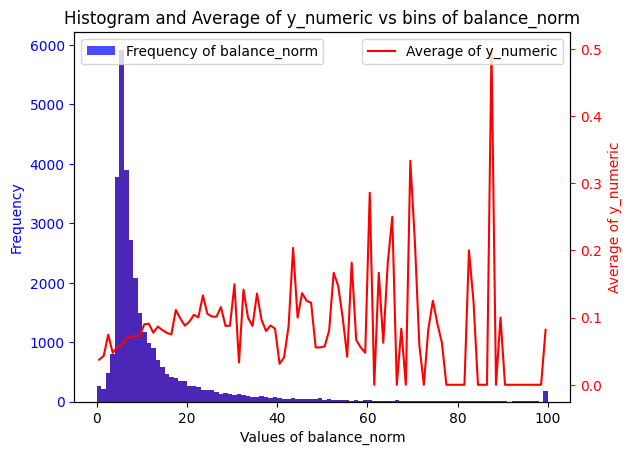

In [39]:
count_and_average_of_label_by_feature_via_bins(train, 'balance_minmax', 'y_numeric', bins=100)

### M2: Take Logarithm

need to shift the data, make sure it's above zero

In [49]:
""" On training set"""
## shift the data
data = train['balance']
lower_bound = data.min() * 1.1
data = data - lower_bound   ## lower_bound < 0
# print(data.min())  ## data > 0

## Take log on training data
train['balance_log'] =  data.apply(lambda x: 0 if x <= 0 else math.log(x))

"""On test set"""
## use the same lower_bound as training set
data = test['balance']
test['balance_log'] =  data.apply(lambda x: 0 if x <= 0 else math.log(x))  ## data <= 0 --> 0

**Check frequency**

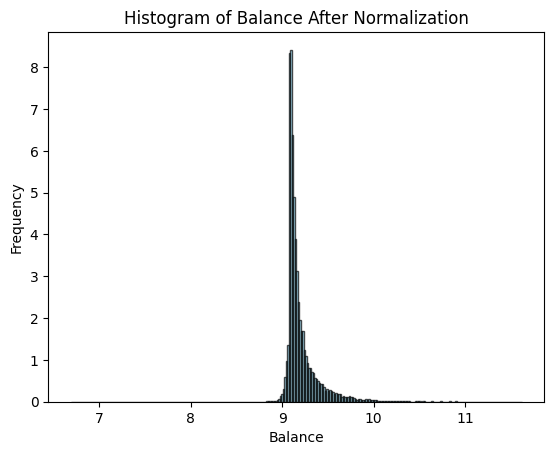

In [69]:
"""Check frequency on traing set after normalization"""
plt.hist(train['balance_log'], bins=300, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Balance After Normalization')
# plt.ylim(0,0.007)
plt.show()

- Become more centered than min-max

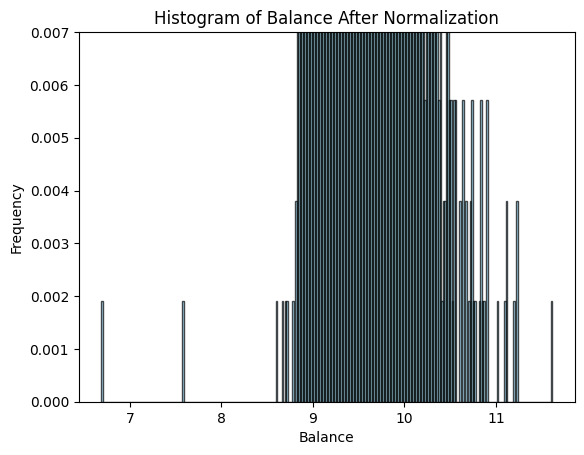

In [63]:
"""Check frequency on traing set after normalization"""
plt.hist(train['balance_log'], bins=300, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Balance After Normalization')
plt.ylim(0,0.007)
plt.show()

**Plot - Count and average of y by balance**

<ipython-input-38-53b0baed200d>:14: RuntimeWarning: invalid value encountered in divide
  bin_means = bin_sum_y / bin_count  # Compute the average for each bin


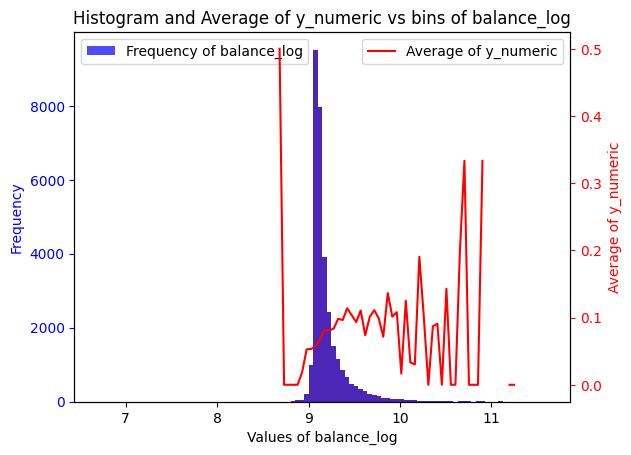

In [66]:
count_and_average_of_label_by_feature_via_bins(train, 'balance_log', 'y_numeric', bins=100)

# Model 1

In [70]:
## specify the type of categorical data in dataframe
cat_attribs = list(train.select_dtypes(include='object').columns)

train[cat_attribs] = train[cat_attribs].astype('category')
test[cat_attribs] = test[cat_attribs].astype('category')

In [74]:
feature_list=["job", "marital", "education", "default", "balance", "housing", \
              "loan", "contact", "day", "month", "duration", "campaign"]
X_train = train[feature_list]
y_train = train['y_numeric']

# X_val = val.drop(columns=['y'])
# y_val = val['y']

X_test = test[feature_list]
y_test = test['y_numeric']

##5-fold cross validation

Xgboost with 5-fold cross validation -- [explanation & implementation](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance)   

PR curve better suit the problem than the ROC curve in imbalanced dataset (#"0" >> #"1") -- [explanation](https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)

Use [callbacks](https://xgboost.readthedocs.io/en/latest/python/callbacks.html) to [get the best model](https://stackoverflow.com/questions/66681443/how-can-i-get-the-trained-model-from-xgboost-cv) from `xgb.cv`.


In [75]:
## define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train, enable_categorical=True)

In [76]:
## define the callback func that will save the best model in cross validation
class SaveBestModel(xgb.callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters

    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model

In [81]:
nfold = 5
params = {'objective': 'binary:logistic', "tree_method": "hist"}

cvboosters = []

## num_boost_round is n_estimators in sklearn
## metrics=['aucpr','logloss']
## early stopped is based on the last metrics
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=nfold, \
                    num_boost_round=150, early_stopping_rounds=10, \
                    metrics=['logloss', 'error', 'aucpr'], seed=123, \
                    callbacks=[SaveBestModel(cvboosters), ])  ## ?? why models are stored in cvboosters?

print(len(cvboosters))
print(cvboosters)
print(len(cv_results))
cv_results[["test-logloss-mean", "test-error-mean", "test-aucpr-mean", "test-aucpr-std"]]

5
[<xgboost.core.Booster object at 0x7979909b9cf0>, <xgboost.core.Booster object at 0x7979909b9f00>, <xgboost.core.Booster object at 0x7979909ba200>, <xgboost.core.Booster object at 0x7979909bab60>, <xgboost.core.Booster object at 0x7979909baa10>]
21


,test-logloss-mean,test-error-mean,test-aucpr-mean,test-aucpr-std
0,0.235805,0.072500,0.496298,0.028422
1,0.204653,0.070125,0.526295,0.027273
2,0.184612,0.065594,0.539144,0.023651
3,0.171687,0.064469,0.538180,0.021972
4,0.162503,0.064000,0.543288,0.026019
5,0.156042,0.063125,0.547920,0.029413
6,0.151623,0.063250,0.548826,0.029048
7,0.147826,0.063094,0.552158,0.029555
8,0.145433,0.062625,0.553493,0.030697
9,0.143227,0.061906,0.554754,0.028619


?? What is contained in the the return value of xgb.cv (i.e. `cv_results`)?
- Case A: nfold = [2,3,4,5], each with `num_boost_round=150, early_stopping_rounds=10`
  - We got `len(cv_results) = [16, 22, 11, 22]`
- Casw B: nfold = [2,3,4,5], each with `num_boost_round=50` and disabtle ~`early_stopping_rounds=10`~
  - We got `len(cv_results) = [50, 50, 50, 50]`

?? Hence, probably `cv_results` only contains the training history of the best (or last) model of the last(or the best-performed?) fold.
- **Best model when `early_stopping_rounds` is specified and `num_boost_round` is not reached. (True, according to [the official Doc](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.cv))**
- Last model when `num_boost_round` is reached (before early stopping or `early_stopping_rounds` is disabled)
- Not sure which fold is in it    

Because,
- If `cv_results` contains all the results of all the nfolds, then Case B should result in `len(cv_results) = 50 * nfold`, but it is not.
- If `cv_results` contrains results when metrics going worse (the increasing aucpr) on the val set, we should see the decreasing `test-aucpr-mean` in it, but not.

?? did not find any documentation on whether all n folds are included in the return value of xgb.cv



## Model & Evaluation

- According to `test-error-mean`, the accuracy has reached above 99% in cross validation.
- We need other metrics (the classification report) of the model.    
  How to get the needed model:
  - As we have saved our best model in `cvboosters`, we can use anyone of it theorically.
  - Or, as we know, from the `cv_results`, we can retrain a model on the `X_train` using `#iterations = len(cv_results)` and keep other params the same.

In [ ]:
xgb_clf = cvboosters[-1]  ## get the best model in the last fold

X_test_dmatrix = xgb.DMatrix(data=X_test, enable_categorical=True)

y_test_proba = xgb_clf.predict(X_test_dmatrix)
y_test_ = (y_test_proba > 0.5).astype(int)

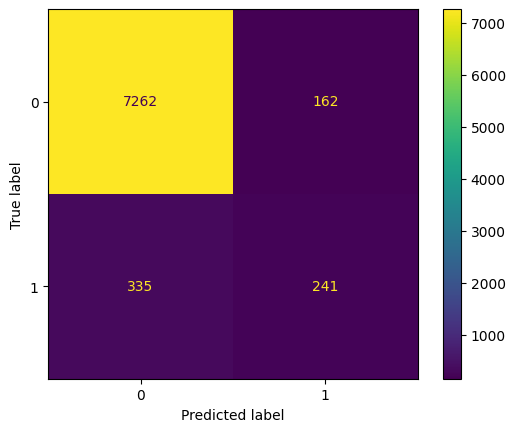

In [ ]:
label=[0,1]
cm_test = confusion_matrix(y_test, y_test_, labels=label)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label)
disp_test.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_test_))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7424
           1       0.60      0.42      0.49       576

    accuracy                           0.94      8000
   macro avg       0.78      0.70      0.73      8000
weighted avg       0.93      0.94      0.93      8000



- **!! Around 40% of the samples that are predicted as "1" are wrong (should be "0").**

# Model 2

In [86]:
feature_list=["job", "marital", "education", "default", "balance_norm", "housing", \
              "loan", "contact", "day", "month", "duration", "campaign"]
X_train = train[feature_list]
y_train = train['y_numeric']

# X_val = val.drop(columns=['y'])
# y_val = val['y']

X_test = test[feature_list]
y_test = test['y_numeric']

In [87]:
## define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train, enable_categorical=True)

In [88]:
nfold = 5
params = {'objective': 'binary:logistic', "tree_method": "hist"}

cvboosters = []

## num_boost_round is n_estimators in sklearn
## metrics=['aucpr','logloss']
## early stopped is based on the last metrics
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=nfold, \
                    num_boost_round=150, early_stopping_rounds=10, \
                    metrics=['logloss', 'error', 'aucpr'], seed=123, \
                    callbacks=[SaveBestModel(cvboosters), ])  ## ?? why models are stored in cvboosters?

print(len(cvboosters))
print(cvboosters)
print(len(cv_results))
cv_results[["test-logloss-mean", "test-error-mean", "test-aucpr-mean", "test-aucpr-std"]]

5
[<xgboost.core.Booster object at 0x79798dc7bc10>, <xgboost.core.Booster object at 0x79798dc79060>, <xgboost.core.Booster object at 0x79798dc7a500>, <xgboost.core.Booster object at 0x79798dc7ace0>, <xgboost.core.Booster object at 0x79798dc7a680>]
25


,test-logloss-mean,test-error-mean,test-aucpr-mean,test-aucpr-std
0,0.235916,0.072500,0.494650,0.029162
1,0.204867,0.070000,0.523225,0.024163
2,0.184821,0.066062,0.534179,0.020474
3,0.171809,0.065125,0.536102,0.018548
4,0.162504,0.064906,0.542120,0.020337
5,0.156134,0.063344,0.547419,0.024078
6,0.151706,0.062812,0.548545,0.027356
7,0.148055,0.063125,0.549493,0.029118
8,0.145532,0.062625,0.553046,0.028833
9,0.143345,0.063031,0.555178,0.030188


- performance are very similar between `balance, _norm, _log`